In [1]:
# in JupyterHub, plot difference in DT across globe between VIIRS and L3S
# HealPix
# once you can get geographic plots to work, everything else is just changing what you want to plot

In [2]:
import xarray
import numpy as np
import pandas
import h5py
import datetime
from ulmo.utils import image_utils
from ulmo.plotting import plotting
import matplotlib.pyplot as plt
import seaborn as sns
import os
import healpy as hp
# os.path.expanduser("~")
import cartopy
from ulmo.analysis.spatial_plots import evals_to_healpix, evals_to_healpix_meds, show_med_LL

In [3]:
# read in 2012 h5 file

analysis_table = pandas.read_parquet('/home/jovyan/SST_L3S_VIIRS_2012.parquet')

In [4]:
eval_tbl = analysis_table
nside = 64

In [5]:
hpma, hp_lons, hp_lats, hpma1 = evals_to_healpix_meds(eval_tbl, nside)

In [6]:
hp_lons # healpix splits into equal area patches, longitudes of these patches
hpma1 # median LL within the patches
hpma1[20000:20100] # negative LL is rare
hpma[20000:20100] # number of cutouts in the healpix patch

masked_array(data=[--, --, 1.0, 1.0, 2.0, --, --, --, --, --, --, --, --,
                   1.0, 1.0, --, --, --, --, 1.0, --, 1.0, 1.0, 8.0, 11.0,
                   16.0, 28.0, 17.0, 21.0, 39.0, 65.0, 87.0, 106.0, 130.0,
                   11.0, --, --, --, --, --, --, 5.0, --, --, --, --, --,
                   --, --, 1.0, --, --, --, --, --, --, 1.0, --, 3.0, 2.0,
                   2.0, --, --, --, --, --, --, --, --, --, 1.0, 2.0, 2.0,
                   5.0, 9.0, 11.0, 20.0, 28.0, 31.0, 36.0, 55.0, 63.0,
                   56.0, 56.0, 4.0, --, --, --, --, --, --, --, --, --,
                   --, --, --, --, --, --],
             mask=[ True,  True, False, False, False,  True,  True,  True,
                    True,  True,  True,  True,  True, False, False,  True,
                    True,  True,  True, False,  True, False, False, False,
                   False, False, False, False, False, False, False, False,
                   False, False, False,  True,  True,  True,  Tru

/opt/conda/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/conda/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:475: UserWarning: The .ylabels_left attribute is deprecated. Please use .left_labels to toggle visibility instead.
  warnings.warn('The .ylabels_left attribute is deprecated. Please '
/opt/conda/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


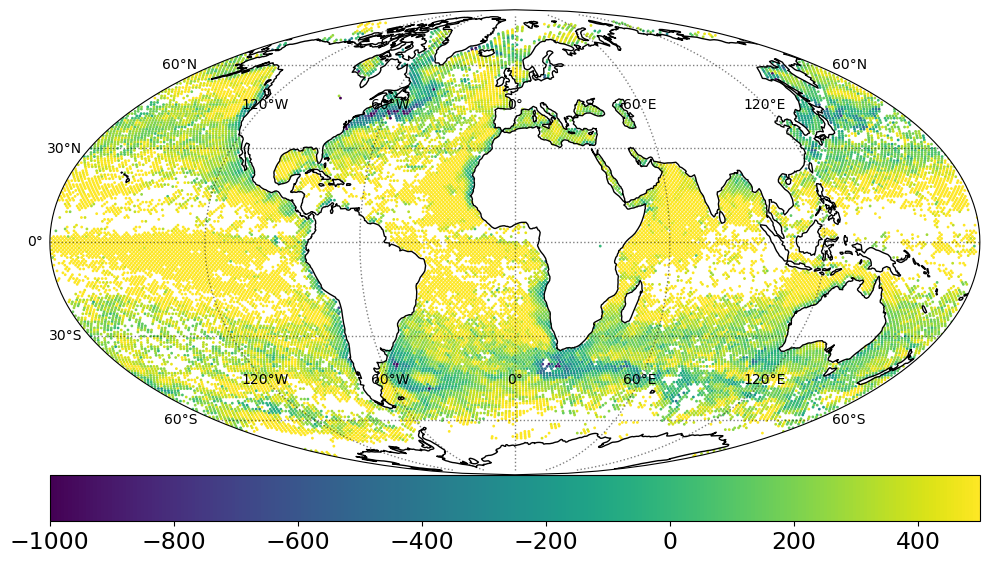

<GeoAxes: >

In [7]:
show_med_LL(analysis_table) # repeats Healpix calculation and then plots w cartopy

In [8]:
file_path = '/home/jovyan/L3S_VIIRS144_2012_preproc.h5'
with h5py.File(file_path, "r") as h5:
    data = h5['valid'][:]
    metadata = h5['valid_metadata'][:]

In [9]:
cutout_indices = metadata[:, [8, 20, 21, 33, 34]]
decoded_data = [[float(item.decode('utf-8')) for item in row] for row in cutout_indices]
column_names = ['VIIRS_DT', 'lat', 'lon', 'T90', 'T10']
df = pandas.DataFrame(decoded_data, columns = column_names)

df.loc[:,'DT'] = df.loc[:,'T90'] - df.loc[:,'T10']

In [10]:
# this makes a plot of DT difference using the h5 file
"""
nside = 8
npix = hp.nside2npix(nside)

num_cutouts = len(df)

center_lat_values = np.zeros(num_cutouts)
center_lon_values = np.zeros(num_cutouts)
dt_values = np.zeros(num_cutouts)

for i in range(num_cutouts):
    viirs_dt = float(df.iloc[i, 0])
    lat = float(df.iloc[i, 1])
    lon = float(df.iloc[i, 2])
    dt = float(df.iloc[i, 5])

    center_lat_values[i] = lat
    center_lon_values[i] = lon

    dt_values[i] = viirs_dt - dt

hp_map = np.zeros(npix)
for i in range(npix):
    hp_map[i] = np.mean(dt_values[i * (4096 // npix):(i + 1) * (4096 // npix)])
fig, ax = plt.subplots(subplot_kw={'projection': 'mollweide'})
im = ax.scatter(np.radians(center_lon_values), np.radians(center_lat_values), c=dt_values, cmap='viridis', s=4, linewidth=1, zorder=10, vmin = -2, vmax = 2)
# hp.cartview(hp_map, cmap='viridis', lonra=[-180, 180], latra=[-90, 90], cbar=False, hold=True)
ax.set_title('Difference in VIIRS_DT and DT 2012')
cbar = plt.colorbar(im, ax=ax, orientation='horizontal')
cbar.set_label('VIIRS_DT - DT')

plt.show()
"""

"\nnside = 8\nnpix = hp.nside2npix(nside)\n\nnum_cutouts = len(df)\n\ncenter_lat_values = np.zeros(num_cutouts)\ncenter_lon_values = np.zeros(num_cutouts)\ndt_values = np.zeros(num_cutouts)\n\nfor i in range(num_cutouts):\n    viirs_dt = float(df.iloc[i, 0])\n    lat = float(df.iloc[i, 1])\n    lon = float(df.iloc[i, 2])\n    dt = float(df.iloc[i, 5])\n\n    center_lat_values[i] = lat\n    center_lon_values[i] = lon\n\n    dt_values[i] = viirs_dt - dt\n\nhp_map = np.zeros(npix)\nfor i in range(npix):\n    hp_map[i] = np.mean(dt_values[i * (4096 // npix):(i + 1) * (4096 // npix)])\nfig, ax = plt.subplots(subplot_kw={'projection': 'mollweide'})\nim = ax.scatter(np.radians(center_lon_values), np.radians(center_lat_values), c=dt_values, cmap='viridis', s=4, linewidth=1, zorder=10, vmin = -2, vmax = 2)\n# hp.cartview(hp_map, cmap='viridis', lonra=[-180, 180], latra=[-90, 90], cbar=False, hold=True)\nax.set_title('Difference in VIIRS_DT and DT 2012')\ncbar = plt.colorbar(im, ax=ax, orientati

In [11]:
# this makes plot of DT difference using analyis table
# I am only plotting a point at the lat/lon, so it doesn't matter which method right now but the h5 does not have LL so good to have both methods

"""
nside = 8
npix = hp.nside2npix(nside)

cutout_indices = analysis_table.iloc[:, [8, 20, 21, 36]]
num_cutouts = len(cutout_indices)

center_lat_values = np.zeros(num_cutouts)
center_lon_values = np.zeros(num_cutouts)
dt_values = np.zeros(num_cutouts)

for i in range(num_cutouts):
    viirs_dt = float(cutout_indices.iloc[i, 0])
    lat = float(cutout_indices.iloc[i, 1])
    lon = float(cutout_indices.iloc[i, 2])
    dt = float(cutout_indices.iloc[i, 3])

    center_lat_values[i] = lat
    center_lon_values[i] = lon

    dt_values[i] = viirs_dt - dt
    
hp_map = np.zeros(npix)
for i in range(npix):
    hp_map[i] = np.mean(dt_values[i * (4096 // npix):(i + 1) * (4096 // npix)])

fig, ax = plt.subplots(subplot_kw={'projection': 'mollweide'})
im = ax.scatter(np.radians(center_lon_values), np.radians(center_lat_values), c=dt_values, cmap='viridis', s=4, linewidth=1, zorder=10, vmin = -2, vmax = 2)
ax.set_title('Difference in VIIRS_DT and DT 2012')
cbar = plt.colorbar(im, ax=ax, orientation='horizontal')
cbar.set_label('VIIRS_DT - DT')

plt.show()
"""

"\nnside = 8\nnpix = hp.nside2npix(nside)\n\ncutout_indices = analysis_table.iloc[:, [8, 20, 21, 36]]\nnum_cutouts = len(cutout_indices)\n\ncenter_lat_values = np.zeros(num_cutouts)\ncenter_lon_values = np.zeros(num_cutouts)\ndt_values = np.zeros(num_cutouts)\n\nfor i in range(num_cutouts):\n    viirs_dt = float(cutout_indices.iloc[i, 0])\n    lat = float(cutout_indices.iloc[i, 1])\n    lon = float(cutout_indices.iloc[i, 2])\n    dt = float(cutout_indices.iloc[i, 3])\n\n    center_lat_values[i] = lat\n    center_lon_values[i] = lon\n\n    dt_values[i] = viirs_dt - dt\n    \nhp_map = np.zeros(npix)\nfor i in range(npix):\n    hp_map[i] = np.mean(dt_values[i * (4096 // npix):(i + 1) * (4096 // npix)])\n\nfig, ax = plt.subplots(subplot_kw={'projection': 'mollweide'})\nim = ax.scatter(np.radians(center_lon_values), np.radians(center_lat_values), c=dt_values, cmap='viridis', s=4, linewidth=1, zorder=10, vmin = -2, vmax = 2)\nax.set_title('Difference in VIIRS_DT and DT 2012')\ncbar = plt.col

In [12]:
# look at difference in DT

cutout_indices = analysis_table.iloc[:, [8, 20, 21, 36]]
cutout_indices.loc[:,'diff_dt'] = cutout_indices.loc[:,'VIIRS_DT'] - cutout_indices.loc[:,'DT']

print("Minimum value:", np.min(cutout_indices.loc[:,'diff_dt']))
print("Maximum value:", np.max(cutout_indices.loc[:,'diff_dt']))
print("Mean:", np.mean(cutout_indices.loc[:,'diff_dt']))
print("Standard Deviation:", np.std(cutout_indices.loc[:,'diff_dt']))

Minimum value: -10.709991455078125
Maximum value: 9.07000732421875
Mean: 0.10928955424229445
Standard Deviation: 0.8288329603954461


/tmp/ipykernel_690/2307269794.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cutout_indices.loc[:,'diff_dt'] = cutout_indices.loc[:,'VIIRS_DT'] - cutout_indices.loc[:,'DT']


In [13]:
diff_dt = cutout_indices.loc[:,'diff_dt']
threshold = np.mean(diff_dt) + 3 * np.std(diff_dt)
filtered_values = diff_dt[diff_dt > threshold]
# np.mean(filtered_values) # most of the values are between the 2nd and 3rd deviations above mean
# filtered_values
# 3063 below three sds, 2052 above
# VIIRS_DT is more likely to be smaller ? 

In [14]:
# cutout with largest difference: -10.7099

cutout_indices.loc[:,'diff_dt'] = cutout_indices.loc[:,'VIIRS_DT'] - cutout_indices.loc[:,'DT']

close_ex = cutout_indices.loc[8]
# far_ex = cutout_indices.loc[cutout_indices['diff_dt'] < -10.7]
far_ex = cutout_indices.loc[94852]

# see notebook entitled 's3_images' for plots

In [15]:
close_ex

VIIRS_DT      0.419983
lat          21.487778
lon        -175.995350
DT            0.510010
diff_dt      -0.090027
Name: 8, dtype: float64

In [16]:
far_ex

VIIRS_DT     1.850006
lat         39.218983
lon        -69.083350
DT          12.559998
diff_dt    -10.709991
Name: 94852, dtype: float64

In [17]:
analysis_table.loc[94852]['VIIRS_filename']

's3://viirs/data/2012/132/20120511061000-OSPO-L2P_GHRSST-SSTsubskin-VIIRS_NPP-ACSPO_V2.61-v02.0-fv01.0.nc'

In [18]:
# plot log likelihoods side by side

"""
nside = 8
npix = hp.nside2npix(nside)

cutout_indices = analysis_table.iloc[:, [20, 21, 3, 37]]
num_cutouts = len(cutout_indices)

center_lat_values = np.zeros(num_cutouts)
center_lon_values = np.zeros(num_cutouts)
viirs_ll_values = np.zeros(num_cutouts)
ll_values = np.zeros(num_cutouts)

for i in range(num_cutouts):
    lat = cutout_indices.iloc[i,0]
    lon = cutout_indices.iloc[i,1]
    viirs_ll = cutout_indices.iloc[i,2]
    ll  = cutout_indices.iloc[i,3]
    
    center_lat_values[i] = lat
    center_lon_values[i] = lon
    viirs_ll_values[i] = viirs_ll
    ll_values[i] = ll
    
combined_values = np.concatenate((viirs_ll_values, ll_values))
vmin = np.min(combined_values)
vmax = np.max(combined_values)

viirs_ll_map = np.zeros(npix)
ll_map = np.zeros(npix)
for i in range(npix):
    viirs_ll_map[i] = np.mean(viirs_ll_values[i * (4096 // npix):(i + 1) * (4096 // npix)])
    ll_map[i] = np.mean(ll_values[i * (4096 // npix):(i + 1) * (4096 // npix)])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6), subplot_kw={'projection': 'mollweide'})

im1 = ax1.scatter(np.radians(center_lon_values), np.radians(center_lat_values), c=viirs_ll_values, cmap='viridis', s=4, linewidth=1, zorder=10, vmin=vmin, vmax=vmax)
ax1.set_title('VIIRS_LL 2012')
cbar1 = plt.colorbar(im1, ax=ax1, orientation='horizontal')
cbar1.set_label('VIIRS_LL')

im2 = ax2.scatter(np.radians(center_lon_values), np.radians(center_lat_values), c=ll_values, cmap='viridis', s=4, linewidth=1, zorder=10,vmin=vmin, vmax=vmax)
ax2.set_title('LL 2012')
cbar2 = plt.colorbar(im2, ax=ax2, orientation='horizontal')
cbar2.set_label('LL')

plt.tight_layout()
plt.show()
"""

"\nnside = 8\nnpix = hp.nside2npix(nside)\n\ncutout_indices = analysis_table.iloc[:, [20, 21, 3, 37]]\nnum_cutouts = len(cutout_indices)\n\ncenter_lat_values = np.zeros(num_cutouts)\ncenter_lon_values = np.zeros(num_cutouts)\nviirs_ll_values = np.zeros(num_cutouts)\nll_values = np.zeros(num_cutouts)\n\nfor i in range(num_cutouts):\n    lat = cutout_indices.iloc[i,0]\n    lon = cutout_indices.iloc[i,1]\n    viirs_ll = cutout_indices.iloc[i,2]\n    ll  = cutout_indices.iloc[i,3]\n    \n    center_lat_values[i] = lat\n    center_lon_values[i] = lon\n    viirs_ll_values[i] = viirs_ll\n    ll_values[i] = ll\n    \ncombined_values = np.concatenate((viirs_ll_values, ll_values))\nvmin = np.min(combined_values)\nvmax = np.max(combined_values)\n\nviirs_ll_map = np.zeros(npix)\nll_map = np.zeros(npix)\nfor i in range(npix):\n    viirs_ll_map[i] = np.mean(viirs_ll_values[i * (4096 // npix):(i + 1) * (4096 // npix)])\n    ll_map[i] = np.mean(ll_values[i * (4096 // npix):(i + 1) * (4096 // npix)])\n

In [19]:
# plot log likelihoods side by side

"""
nside = 8
npix = hp.nside2npix(nside)

cutout_indices = analysis_table.iloc[:, [20, 21, 3, 37]]
num_cutouts = len(cutout_indices)

center_lat_values = np.zeros(num_cutouts)
center_lon_values = np.zeros(num_cutouts)
viirs_ll_values = np.zeros(num_cutouts)
ll_values = np.zeros(num_cutouts)

for i in range(num_cutouts):
    lat = cutout_indices.iloc[i,0]
    lon = cutout_indices.iloc[i,1]
    viirs_ll = cutout_indices.iloc[i,2]
    ll  = cutout_indices.iloc[i,3]
    
    center_lat_values[i] = lat
    center_lon_values[i] = lon
    viirs_ll_values[i] = viirs_ll
    ll_values[i] = ll

viirs_ll_map = np.zeros(npix)
ll_map = np.zeros(npix)
for i in range(npix):
    viirs_ll_map[i] = np.mean(viirs_ll_values[i * (4096 // npix):(i + 1) * (4096 // npix)])
    ll_map[i] = np.mean(ll_values[i * (4096 // npix):(i + 1) * (4096 // npix)])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6), subplot_kw={'projection': 'mollweide'})

im1 = ax1.scatter(np.radians(center_lon_values), np.radians(center_lat_values), c=viirs_ll_values, cmap='viridis', s=4, linewidth=1, zorder=10)
ax1.set_title('VIIRS_LL 2012')
cbar1 = plt.colorbar(im1, ax=ax1, orientation='horizontal')
cbar1.set_label('VIIRS_LL')

im2 = ax2.scatter(np.radians(center_lon_values), np.radians(center_lat_values), c=ll_values, cmap='viridis', s=4, linewidth=1, zorder=10)
ax2.set_title('LL 2012')
cbar2 = plt.colorbar(im2, ax=ax2, orientation='horizontal')
cbar2.set_label('LL')

plt.tight_layout()
plt.show()
"""

"\nnside = 8\nnpix = hp.nside2npix(nside)\n\ncutout_indices = analysis_table.iloc[:, [20, 21, 3, 37]]\nnum_cutouts = len(cutout_indices)\n\ncenter_lat_values = np.zeros(num_cutouts)\ncenter_lon_values = np.zeros(num_cutouts)\nviirs_ll_values = np.zeros(num_cutouts)\nll_values = np.zeros(num_cutouts)\n\nfor i in range(num_cutouts):\n    lat = cutout_indices.iloc[i,0]\n    lon = cutout_indices.iloc[i,1]\n    viirs_ll = cutout_indices.iloc[i,2]\n    ll  = cutout_indices.iloc[i,3]\n    \n    center_lat_values[i] = lat\n    center_lon_values[i] = lon\n    viirs_ll_values[i] = viirs_ll\n    ll_values[i] = ll\n\nviirs_ll_map = np.zeros(npix)\nll_map = np.zeros(npix)\nfor i in range(npix):\n    viirs_ll_map[i] = np.mean(viirs_ll_values[i * (4096 // npix):(i + 1) * (4096 // npix)])\n    ll_map[i] = np.mean(ll_values[i * (4096 // npix):(i + 1) * (4096 // npix)])\n\nfig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6), subplot_kw={'projection': 'mollweide'})\n\nim1 = ax1.scatter(np.radians(center

In [20]:
print("VIIRS Minimum value:", np.min(analysis_table.loc[:,'VIIRS_LL']))
print("VIIRS Maximum value:", np.max(analysis_table.loc[:,'VIIRS_LL']))
print("VIIRS Mean:", np.mean(analysis_table.loc[:,'VIIRS_LL']))
print("VIIRS Standard Deviation:", np.std(analysis_table.loc[:,'VIIRS_LL']))

print("L3S Minimum value:", np.min(analysis_table.loc[:,'LL']))
print("L3S Maximum value:", np.max(analysis_table.loc[:,'LL']))
print("L3S Mean:", np.mean(analysis_table.loc[:,'LL']))
print("L3S Standard Deviation:", np.std(analysis_table.loc[:,'LL']))

VIIRS Minimum value: -7527.6396484375
VIIRS Maximum value: 1136.343017578125
VIIRS Mean: 236.72816
VIIRS Standard Deviation: 286.133056640625
L3S Minimum value: -12129.490234375
L3S Maximum value: 1142.1265869140625
L3S Mean: 307.61035079559497
L3S Standard Deviation: 302.9994250357969
